# FDN Reverberator - DAAP Project

Students: 

*   Federico Maver ( ID: 10565151, MATR: 952840 )
*   Filippo Gualtieri ( ID: 10557065, MATR: 953546 )

In [754]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa, librosa.display
import scipy as sp
import IPython.display as ipd
import copy
import random
import warnings

## Scheme of Feedback Delay Network

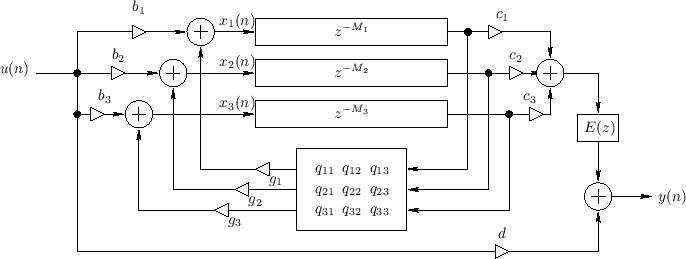

In [755]:
ipd.Image(filename = "images/FDNScheme.png")

## Function Definitions

In [756]:
def applyFDN(sig, t60, mixMatrix, T, B, C, G ,fs, filterType='1stOrder', showPlot=False):
    
    N = sig.shape[0]
    channel = np.arange(N)
    
    # Select delay lenghts
    M_min = int(np.ceil(0.15*np.max(t60)*fs))
    M = generateDelays(M_min, N, shuffle=False)

    if(showPlot == True):
        print('Selected delay lengths [ms]: {}'.format((M/fs)*1000))
    # TODO: select numbers according to min desired length

    sigFDN = np.append(sig, np.zeros((N, int(3*np.max(t60)*fs))), axis=1) # TODO modify sig length according to t60 # + np.max(M)

    bufferSize = np.max(M) + T+1

    # filter design
    if(filterType == 'multiband'):
        taps = np.zeros((N,T))
        taps = multibandEqualizer(M, T, t60, freqs, fs, plot=showPlot)

    if(filterType == 'ort1stOrder'):
        filterCoeff = []
        filterCoeff = ortFilter1st(M, t60, fs, plot=showPlot)
        print(filterCoeff.shape)

    if(filterType == '1stOrder'):
        filterCoeff = []
        filterCoeff = filter1st(M, t60, fs, plot=showPlot)
        print(filterCoeff.shape)

    mix = np.zeros(N).T
    filtered = np.zeros(N).T
    out = np.zeros((N, sigFDN.shape[-1]))


    writeIndex = copy.deepcopy(M)
    readIndex = 0 #np.zeros(N, dtype=int).T

    # print(writeIndex, readIndex)

    filterIndex = 0 # copy.deepcopy(readIndex)
    buffer = np.zeros((N, bufferSize))

    for j in range(sigFDN.shape[-1]): 

        # read the samples from the buffers
        # extract output at readIndex
        out[channel, j] = C*buffer[channel, readIndex]

        # now mix up signals by applying feedback matrix (Q)
        mix = np.matmul(mixMatrix, buffer[channel, readIndex]) # np.sum(mixMatrix*buffer[channel, readIndex], axis=1) #

        # filter the signals (g) to obtain the correct t_60:
        if(filterType == 'multiband'):
            # multiband FIR: y(n) = h_0*x(n) + h_1*x(n-1) + h_2*x(n-2) + ...
            filterIndex = readIndex # set current sample in the buffer to the filter
            # current sample is multiplied by first tap (h_0)
            filtered = mix*taps[channel, 0]
            # multiply previous samples for the other taps
            for tapId in range(T-1): 
                filterIndex = filterIndex-1 # previous sample index
                if(filterIndex<0):
                    filterIndex = bufferSize-1     
                # cumulative sum of (samples (going backwards) * relative tap)      
                filtered = filtered + buffer[channel, filterIndex]*taps[channel,tapId+1] 

        if(filterType == '1stOrder' or filterType=='ort1stOrder'):
            # multiband IIR: a_0*y(n) = b_0*x(n) + a_1*y(n-1) + b_1*x(n-1)
            filtered = filtered*filterCoeff[channel, 0, 1] + mix*filterCoeff[channel, 1, 0]

        # update buffer by writing new sample in correct position (delay)
        buffer[channel, writeIndex] = B*sigFDN[channel, j] + filtered*G 

        # check if indices of the circular buffer are ok
        readIndex = readIndex + 1
        writeIndex = writeIndex + 1
        if(readIndex>=bufferSize):
            readIndex = 0
        writeIndex[writeIndex>=bufferSize] = 0
        
    # tone equalization filter
    a, b = spectralEqualizer(t60, fs, plot=showPlot)
    output = np.zeros(sig.shape[-1])
    output = sp.signal.lfilter(b, a, np.sum(out, axis= 0)) 
    # normalization
    # output = (output / np.max(output))*np.max(signal) # normalize output to the original signal level

    # final result
    return output, M

In [757]:
def generateDelays(M_min, N, shuffle=False):
    primeN = []

    # generate some prime numbers...
    for num in range(2,501):
        prime = True
        for i in range(2,num):
            if (num%i==0):
                prime = False
        if prime:
            primeN.append(num)

    # compute M starting from (different) prime numbers
    M = []
    for i in primeN:
        m = np.floor(0.5+np.log(M_min)/np.log(i))
        if i**m>M_min:
            M.append(int(i**m))

    if(shuffle==False):
        M = np.sort(M)
    else:
        random.shuffle(M)

    return np.array(M[:N])

In [758]:
def generateMixMatrix(N, type='Had'):
    if(type=='Had'):
        # hadamard
        if((N & (N-1) == 0) and N != 0):
            mixMatrix = 1/np.sqrt(N)*sp.linalg.hadamard(N)
        else:
            mixMatrix = np.eye(N)
            warnings.warn("MIXING MATRIX DISABLED! Hadamard matrices can be computed only when N is a power of 2. Please, select N accordingly.")

    if(type=='Hous'):
        #householder
        u = np.ones(N)
        mixMatrix = np.identity(N)-2/N*u*u.T

    return np.array(mixMatrix)

In [759]:
# diffusion before FDN:

def diffusionStep(sig, meanDelay, mixMatrix, fs):
    
    N = sig.shape[0]
    channel = np.arange(N)

    delayDiff = []
    maxDelayDiff = meanDelay*fs
    for i in range(N):
        delayDiff.append(int((i + np.random.rand())*maxDelayDiff/N))

    delayDiff = np.array(delayDiff)

    sigDiff = np.append(sig, np.zeros((N, np.max(delayDiff))), axis=1) # TODO modify sig length according to t60

    bufferSizeDiff = np.max(delayDiff) + 1
    mixDiff = np.zeros(N).T
    outDiff = np.zeros((N, sigDiff.shape[-1]))
    bufferDiff = np.zeros((N, bufferSizeDiff))

    writeIndexDiff = copy.deepcopy(delayDiff)
    readIndexDiff = 0 

    for j in range(sigDiff.shape[-1]):  

        outDiff[:, j] = np.matmul(mixMatrix, bufferDiff[:, readIndexDiff]*np.sign(np.random.rand(N)-0.5))

        random.shuffle(bufferDiff[:, readIndexDiff])    

        bufferDiff[channel, writeIndexDiff] = sigDiff[channel, j]

        # check if indices of the circular buffer are ok
        readIndexDiff = readIndexDiff + 1
        writeIndexDiff = writeIndexDiff + 1
        if(readIndexDiff>=bufferSizeDiff):
            readIndexDiff = 0
        writeIndexDiff[writeIndexDiff>=bufferSizeDiff] = 0
        
    return outDiff

In [760]:
def diffuse(sig, delays, mixMatrix, fs, showPlot):
    outputDiff = sig
    for delay in delays:
        outputDiff = diffusionStep(outputDiff, delay, mixMatrix, fs)
            
    if(showPlot==True):
        print('Selected {0} diffusion Times (ms): {1}'.format(len(delays), delays))
        time = np.arange(0, outputDiff.shape[-1]) / fs 
        plt.plot(time, np.sum(outputDiff, axis= 0))
        plt.title('Diffused Signal')
        plt.xlabel('Time [s]')
        ipd.display(ipd.Audio(np.sum(outputDiff, axis= 0), rate=fs))
        
    return outputDiff

### Filters

In [761]:
#plot a filter
def plotFilter(w, h, M_i):
        fig, ax1 = plt.subplots()
        if(M_i!='eq'):
                ax1.set_title('Filter applied to delay line with M={}'.format(M_i))
        else:
                ax1.set_title('Spectral Equalizer')
        ax1.plot(w, 20 * np.log10(abs(h)), 'b')
        ax1.set_ylabel('Amplitude [dB]', color='b')
        ax1.set_xlabel('Frequency [rad/sample]')
        plt.show()

In [762]:
#1st order LP filter
def filter1st(M, t60, fs, plot=False):
    filterCoeffs = []
    for M_i in M:
        R_M = []
        # R_M = 1-(6.91*M_i/t60*fs)
        for t60_f in t60:
            R_M.append(10**((-3*M_i)/(t60_f*fs))) 
            
        # pole
        p_i = (R_M[0]-R_M[-1])/(R_M[0]+R_M[-1])

        # gain
        g_i = 2*(R_M[0]*R_M[-1])/(R_M[0]+R_M[-1])   

        b = [g_i, 0]
        a = [1, -p_i]

        if(plot==True):
            w, h = sp.signal.freqz(b, a, fs=fs)
            print('Filter Coefficients: [a, b]=', [a, b])
            plotFilter(w, h, M_i)

        filterCoeffs.append([a, b])

    return np.array(filterCoeffs)


In [763]:
#orthogonalized 1st order LP filter (NOT WORKING)

def ortFilter1st(M, t60, fs, plot=False):
        filterCoeffs = []
        for M_i in M:
                # gain
                g_i = 10**((-3*M_i)/(t60[0]*fs))

                # pole and zero
                p_i = np.log(10)/4 * np.log10(g_i) * (1-(1/(t60[-1]/t60[0])**2))

                b = [g_i*(1-p_i), 0]
                a = [1, -p_i]

                if(plot==True):
                        w, h = sp.signal.freqz(b, a, fs=fs)
                        print('Filter Coefficients: [a, b]=', [a, b])
                        plotFilter(w, h, M_i)
                
                filterCoeffs.append([a, b])

        return np.array(filterCoeffs)


In [764]:
#multiband filter (preferred)

def multibandEqualizer(M, T, t60, freqs, fs, plot=False):
    filterTaps = []
    for M_i in M:

        G_i = []
        # evaluate correct gains (one per band)
        for t60_f in t60:
            G_i.append(10**((-3*M_i)/(t60_f*fs))) 

        taps = sp.signal.firwin2(numtaps=T, freq=freqs, gain=G_i, fs=fs)

        if(plot==True):
            w, h = sp.signal.freqz(taps, fs=fs)
            plotFilter(w, h, M_i)

        filterTaps.append(taps.tolist())

    return np.array(filterTaps)

In [765]:
#final spectral equalizer
def spectralEqualizer(t60, fs, plot=False):
    b_coeff = (1-(t60[-1]/t60[0]))/(1+(t60[-1]/t60[0]))

    b = [1, -b_coeff]
    a = [1-b_coeff]
    if(plot==True):
        w, h = sp.signal.freqz(b,a, fs=fs)
        plotFilter(w, h, 'eq')

    return [a, b]

## Reverb Computation:

### Signal

In [766]:
fs = 22050 # sampling rate
# signal = np.append(0.5*np.sin(2*np.pi*10000*np.arange(0,0.1,1/fs)),np.zeros(15000)) #sp.signal.unit_impulse(22050)
signal = sp.signal.unit_impulse(5000)
# signal, _ = librosa.load('audio/AudioSamples/Voice_ChangeHasComeToAmerica.wav', sr=fs, mono=True)


# SIG = np.fft.fft(signal)
# FREQ = np.fft.fftfreq(len(signal), d=1/fs)
# plt.plot(FREQ, np.abs(SIG))

### Parameters

In [767]:
# parameters
N = 8 # number of parallel delay lines

# reverberation time should be function of frequency, from 0 to fs/2
T = 5 # filter taps
t60 = [0.5, 0.5, 0.3]
freqs = np.linspace(0, fs/2, len(t60))

print('Frequency bands {0} & relative reverberation times {1}'.format(freqs, t60)) 

# weighting coefficients:
B = np.repeat(1, N).T
C = np.repeat(1, N).T
G = np.repeat(1, N).T
mixCoeff = 0.1

# multichannel input signal:
inputSig_mul = np.tile(signal, (N,1))

Frequency bands [    0.   5512.5 11025. ] & relative reverberation times [0.5, 0.5, 0.3]


Selected 2 diffusion Times (ms): [0.08, 0.05]


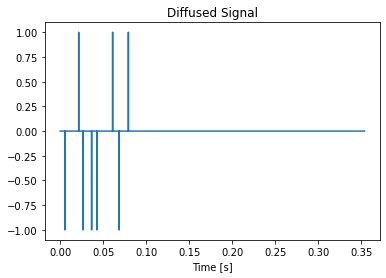

In [768]:
# diffusion steps:

delays = [0.08, 0.05]#[0.2,0.25]

mixMatrix = generateMixMatrix(N, 'Had')
diff=1

if(diff==1):
    outputDiff = diffuse(inputSig_mul, delays, mixMatrix, fs, True)
else:
     outputDiff = inputSig_mul

Selected delay lengths [ms]: [ 76.23582766  83.85487528  92.87981859  99.18367347  99.63718821
 100.1814059  108.88888889 127.39229025]


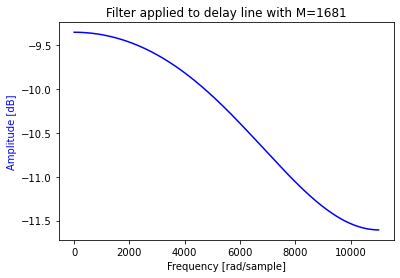

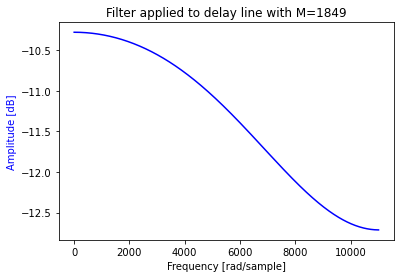

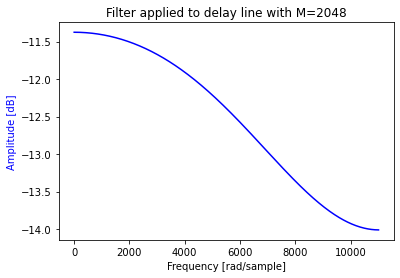

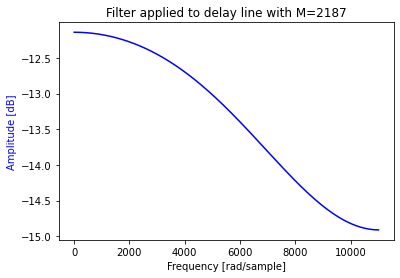

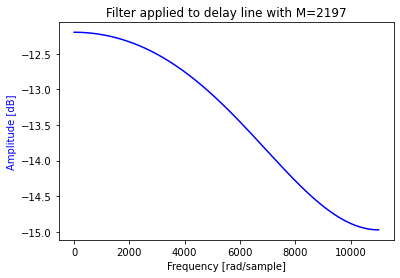

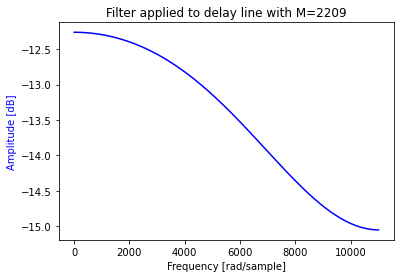

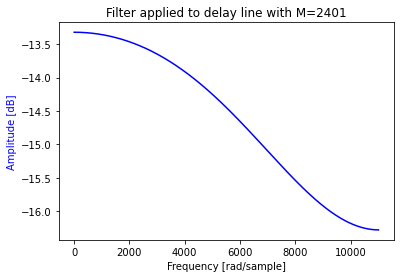

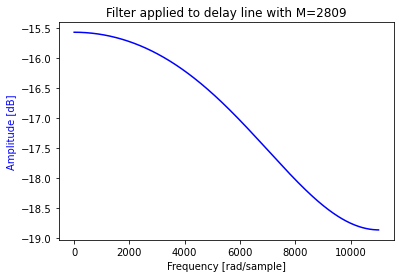

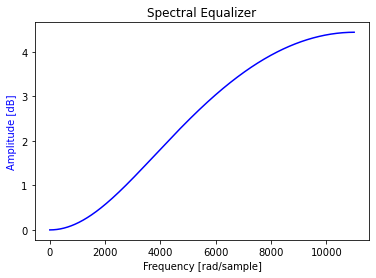

In [769]:
# FDN step:
filterType = 'multiband'

mixMatrix = generateMixMatrix(N, 'Had')

outputFDN, M = applyFDN(outputDiff, t60, mixMatrix, T, B, C, G, fs, filterType, True)

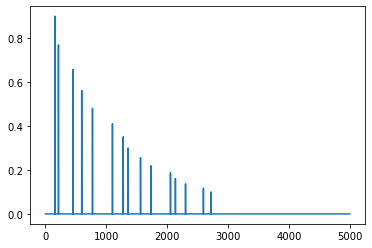

In [770]:
# early reflections implementation:

# diffusion before FDN:

sigER = signal

N_er = 15

delaysER = []
maxDelayER = np.max(M)

#delaysER = maxDelayER - np.floor(maxDelayER*np.e**(-np.linspace(0, np.log(maxDelayER), num=N_er, dtype=int)))

for i in range(N_er):
    delaysER.append(int((i + np.random.rand())*maxDelayER/N_er))

delaysER = np.array(delaysER)

# print(delaysER)

maxWeight = 0.9
minWeight = 0.1
weights = np.e**(np.linspace(np.log(maxWeight), np.log(minWeight), num=N_er))


tapLine = np.arange(N_er)

# print(tapLine)

bufferSize = np.max(delaysER) + 2
    
outER = np.zeros( len(sigER))
bufferER = np.zeros((N_er, bufferSize))

writeIndex = np.array(delaysER)
readIndex = 0

for j in range(len(sigER)):  
        
    bufferER[tapLine, writeIndex] = sigER[j]

    outER[j] = np.sum(bufferER[tapLine, readIndex]*weights, axis=0)  

    # check if indices of the circular buffer are ok
    readIndex = readIndex + 1
    writeIndex = writeIndex + 1
    if(readIndex>=bufferSize):
        readIndex = 0
    writeIndex[writeIndex>=bufferSize] = 0
        
plt.plot(outER)

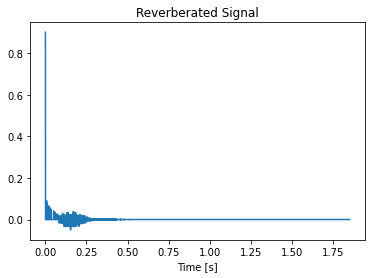

In [771]:
# sigDry = np.append(np.zeros(np.min(M)), signal)

pad = np.max([len(signal), len(outputFDN), outputDiff.shape[-1], len(outER)])

output = np.append(outputFDN, np.zeros(pad-len(outputFDN)))
sigDry = np.append(signal, np.zeros(pad-len(signal)))
outputDiffDirectSum = np.append(np.sum(outputDiff, axis= 0), np.zeros(pad-outputDiff.shape[-1]))
outputER = np.append(outER, np.zeros(pad-len(outER)))

output = mixCoeff*(output+outputER) + (1-mixCoeff)*sigDry  # outputDiffDirectSum

time = np.arange(0, len(output)) / fs
plt.plot(time, output)
plt.title('Reverberated Signal')
plt.xlabel('Time [s]')

ipd.display(ipd.Audio(output, rate=fs))

In [772]:
path = 'audio/AudioSamples/'
filenames = ['voiced_a', 'Chirp_100-15kHz', 'Clap808', 'OSR_us_000_0010_8k', 'Drums', 'Banjo', 'ChordShort', 'FluteMelody', 
             'GuitarPowChord', 'PanFluteNote', 'simple_piano', 'Snap', 'Voice_AndGetYourPaper', 
             'Voice_ChangeHasComeToAmerica']

filename = filenames[-2]

test, _ = librosa.load(path+filename+'.wav', sr=fs, mono=True)

conv = sp.signal.fftconvolve(output, test)
ipd.display(ipd.Audio(test, rate=fs))
ipd.display(ipd.Audio(conv, rate=fs))

In [773]:
print(int(np.max(t60)*fs))

11025
